In [1]:
#coding=utf-8 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,learning_curve,validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn.tree import DecisionTreeClassifier


df1 = pd.read_csv("D:\桌面\inside_trade.csv")
df2 = pd.read_csv("D:\桌面\sample1.csv",encoding='GB18030')
#df3 = pd.read_csv('D:\桌面\comparision-sample.csv',encoding = 'GB18030')
#df2 = pd.concat([df2,df3]).drop_duplicates()

print(df1.iloc[209][0])
factor = pd.DataFrame()

C600667


In [2]:
for i in df1.index:
    index = df2.loc[(df2.上市公司代码_Comcd == df1.loc[i][0])&(df2.日期_Date == df1.loc[i][1])].index[0]
    if i == 0:
        estimate_df = df2.loc[index-120:index-31]
    else:
        estimate_df = pd.concat([estimate_df,df2.loc[index-120:index-31]],ignore_index=True)
        
estimate_df.dropna(axis='index', how='any', subset=['流通市值加权平均市场日收益率_Drettmv','日收益率_Dret'],inplace = True)
estimate_df.shape

(20353, 77)

In [3]:
for i in df1.index:
    index = df2.loc[(df2.上市公司代码_Comcd == df1.loc[i][0])&(df2.日期_Date == df1.loc[i][1])].index[0]
    if i == 0:
        window_df = df2.loc[index-30:index+29]
        
    else:
        window_df = pd.concat([window_df,df2.loc[index-30:index+29]],ignore_index=True)
        
        
window_df.dropna(axis='index', how='any', subset=['流通市值加权平均市场日收益率_Drettmv','日收益率_Dret'],inplace = True)
window_df.shape

(12382, 77)

In [4]:
car = []
day_return = []
amp_day_return = []
amp_car = []
beta = []
std = []
transaction = []
turnover_rate = []
eps = []
roe = []
naps = []

for i in df1.index:
    regression = estimate_df.loc[(estimate_df.上市公司代码_Comcd == df1.loc[i][0])]
    predict = window_df.loc[(window_df.上市公司代码_Comcd == df1.loc[i][0])]
    
    x_train = regression.流通市值加权平均市场日收益率_Drettmv
    y_train = regression.日收益率_Dret
    if x_train.isnull().all() or y_train.isnull().all():
        print(df1.iloc[i][0])
        continue
    else:
        x_train = np.array(x_train).reshape(-1,1)
        x_test = predict.流通市值加权平均市场日收益率_Drettmv
        x_test = np.array(x_test).reshape(-1,1)
        y_test = predict.日收益率_Dret
    
        linreg = LinearRegression()
        linreg.fit(x_train, y_train)
    
    
    #beta = linreg.coef_ #beta
    
    
        y_pred = linreg.predict(x_test)
    
        car.append(sum(y_test-y_pred))# Cumulative Abnormal Return
        day_return.append(y_test.mean())# Daily Return 
        amp_day_return.append(max(y_test)-min(y_test))# Amplitude of Daily Returns
        amp_car.append(max(y_test-y_pred)-min(y_test-y_pred))#Cumulative Amplitude of Daily Returns
        beta.append(list(linreg.coef_)[0])#Beta
        std.append(y_test.std())# Standard Deviation of Daily Return
        transaction.append(predict.成交量_Trdvol.mean()/regression.成交量_Trdvol.mean())# Transaction
        turnover_rate.append(predict.总股数日换手率_DFulTurnR.mean()/100)# Turnover Rate
        eps.append(predict['每股收益(摊薄)(元/股)_EPS'].mean()) #EPS
        roe.append(predict['净资产收益率(摊薄)_ROE'].mean()) #ROE
        naps.append(predict['每股净资产(元/股)_NAPS'].mean()) #NAPS
    
       
Car = np.asarray(car)
Day_Return = np.asarray(day_return)
Amp_Day_Return = np.asarray(day_return)
Amp_Car = np.asarray(amp_car)
Beta = np.asarray(beta)
Std = np.asarray(std)
Transaction = np.asarray(transaction)
Turnover_Rate = np.asarray(turnover_rate)
Eps = np.asarray(eps)
Roe = np.asarray(roe)
Naps = np.asarray(naps)


factor['Number'] = df1.Number
factor['Car'] = Car
factor['Amp_Car'] = Amp_Car
factor['Day_Return'] = Day_Return
#factor['Amp_Day_Return'] = Amp_Day_Return
#factor['Transaction'] = Transaction
#factor['Turnover_Rate'] = Turnover_Rate
factor['Std'] = Std
factor['Beta'] = Beta
factor['Eps'] = Eps
factor['Roe'] = Roe
factor['Naps'] = Naps
factor['Target'] = df1.Inside_trade

factor

,Number,Car,Amp_Car,Day_Return,Std,Beta,Eps,Roe,Naps,Target
0,C000975,-0.237356,0.157316,0.000356,0.035153,1.436558,0.005763,0.281678,1.468983,1
1,C002464,-0.016548,0.191605,-0.004490,0.058176,1.153522,0.320000,6.072400,5.340000,1
2,C300105,-0.192893,0.108051,-0.001326,0.025744,0.928853,0.768966,7.487986,10.168966,1
3,C300204,-0.086250,0.165362,0.003522,0.038298,0.885433,0.870000,5.510300,15.830000,1
4,C600076,0.128955,0.107892,0.002336,0.024917,0.955609,-0.044182,-22.072098,0.179455,1
...,...,...,...,...,...,...,...,...,...,...
231,C000837,0.011846,0.127132,0.004046,0.029109,1.023970,0.218475,8.288680,2.578475,0
232,C000551,-0.201147,0.198339,0.003859,0.037453,0.951540,0.335862,9.982593,3.315862,0
233,C002200,0.076492,0.170434,-0.000965,0.032956,0.947780,0.156364,0.581764,4.924545,1
234,C000663,-0.168557,0.143757,-0.002929,0.028964,1.151061,0.003621,-0.016107,2.143793,0


In [38]:
factor = factor.sample(frac=1).reset_index(drop=True)
X = factor.drop(['Number','Target'],axis = 1)
X = (X - X.mean()) / (X.std())
y = factor.Target

In [39]:
def train(X,y,model,i):
    X_train_full, X_valid_full, y_train,y_valid = train_test_split(X, y, train_size = 0.7, test_size = 0.3,random_state = i)

    numerical_col = [cname for cname in X.columns if X[cname].dtype in ['int64','float64']]
    categorical_col = [cname for cname in X.columns if X[cname].nunique()<10 and X[cname].dtype == 'object']
    my_cols = numerical_col + categorical_col
    X_train = X_train_full[my_cols].copy()
    X_valid = X_valid_full[my_cols].copy()


    numerical_transformer = SimpleImputer(missing_values = np.nan,strategy = 'most_frequent')
    categorical_transformer = Pipeline(steps = [
        ('imputer', SimpleImputer(missing_values = np.nan,strategy = 'most_frequent')),
        ('onehot',OneHotEncoder(handle_unknown = 'ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num',numerical_transformer,numerical_col),
        ('cat',categorical_transformer,categorical_col)
    ])

    my_pipeline = Pipeline(steps = [
        ('preprocessor',preprocessor),
        ('model',model)
    ])

    my_pipeline.fit(X_train,y_train)

    preds = my_pipeline.predict(X_valid)

    scores1 = -1 * cross_val_score(my_pipeline, X, y, cv = 5, scoring = 'neg_mean_absolute_error')
    scores2 = mean_absolute_error(preds,y_valid)
    return my_pipeline,scores1.mean()

In [40]:
model_xgb = XGBClassifier(n_estimators = 130 ,random_state = 10,learning_rate = 0.1)
model_rf = RandomForestClassifier(n_estimators = 100 ,max_depth = 7, min_samples_split = 3)
model_svc = SVC(C=4.6,gamma='auto')
model_log = LogisticRegression(penalty="l2", C=0.05, solver="liblinear",class_weight = 'balanced')
model_dtc = DecisionTreeClassifier(criterion = 'gini',max_depth = 4, min_samples_split = 6)
model_gbc = GradientBoostingClassifier(n_estimators = 90, learning_rate = 0.2,subsample = 0.6)
my_pipeline_xgb,score_xgb = train(X,y,model_xgb,10)
my_pipeline_rf,socre_rf = train(X,y,model_rf,20)
my_pipeline_svc,socre_svc = train(X,y,model_svc,30)
my_pipeline_log,socre_log = train(X,y,model_log,40)
my_pipeline_dtc,socre_dtc = train(X,y,model_dtc,50)
my_pipeline_gbc,socre_gbc = train(X,y,model_gbc,60)

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
def roc(my_pipeline,X,y):
    predict = my_pipeline.predict(X)
    fpr,tpr,threshold = roc_curve(y, predict)
    roc_auc = auc(fpr,tpr)
    return fpr,tpr,roc_auc

In [42]:
fpr_xgb,tpr_xgb,roc_auc_xgb = roc(my_pipeline_xgb,X,y)
fpr_rf,tpr_rf,roc_auc_rf = roc(my_pipeline_rf,X,y)
fpr_svc,tpr_svc,roc_auc_svc = roc(my_pipeline_svc,X,y)
fpr_log,tpr_log,roc_auc_log = roc(my_pipeline_log,X,y)
fpr_dtc,tpr_dtc,roc_auc_dtc = roc(my_pipeline_dtc,X,y)
fpr_gbc,tpr_gbc,roc_auc_gbc = roc(my_pipeline_gbc,X,y)

<Figure size 432x288 with 0 Axes>

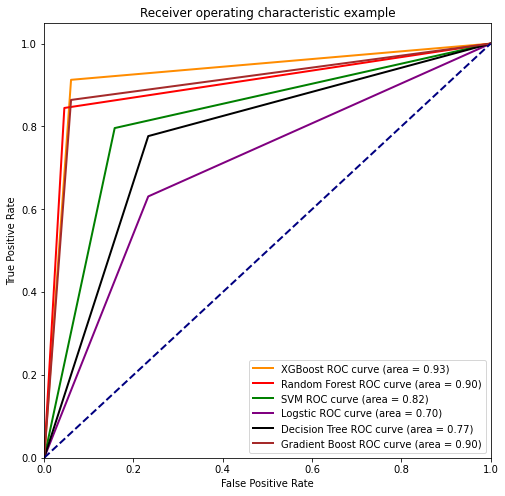

In [43]:
plt.figure()
lw = 2
plt.figure(figsize=(8,8))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
         lw=lw, label='XGBoost ROC curve (area = %0.2f)' % roc_auc_xgb) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr_rf, tpr_rf, color='red',
         lw=lw, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_svc, tpr_svc, color='green',
         lw=lw, label='SVM ROC curve (area = %0.2f)' % roc_auc_svc)
plt.plot(fpr_log, tpr_log, color='purple',
         lw=lw, label='Logstic ROC curve (area = %0.2f)' % roc_auc_log)
plt.plot(fpr_dtc, tpr_dtc, color='black',
         lw=lw, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_dtc)
plt.plot(fpr_gbc, tpr_gbc, color='brown',
         lw=lw, label='Gradient Boost ROC curve (area = %0.2f)' % roc_auc_gbc)
plt.plot([0, 1], [0, 1],color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [44]:
def draw_learning_curve(model,X,y,model_name):
    fig,ax=plt.subplots(1,1,figsize=(6,6))
    train_sizes,train_scores,test_scores=learning_curve(model,X,y,cv=5,n_jobs=4)
    mean_train = np.mean(train_scores,1)  #(5,)
    # 得到得分范围的上下界
    upper_train = np.clip(mean_train + np.std(train_scores,1),0,1) 
    lower_train = np.clip(mean_train - np.std(train_scores,1),0,1)
    
    mean_test = np.mean(test_scores,1)
    # 得到得分范围的上下界
    upper_test = np.clip(mean_test + np.std(test_scores,1),0,1) 
    lower_test = np.clip(mean_test - np.std(test_scores,1),0,1)



    ax.set_ylim((0.4,1.1)) # 设置子图的纵坐标的范围为（0.7~1.1）
    ax.set_xlabel("training examples") # 设置子图的x轴名称
    ax.set_ylabel("score")
    ax.grid() # 画出网图
    ax.plot(train_sizes,np.mean(train_scores,axis=1),'o-',color='r',label = model_name+' Train Score')
    # 画训练集数据分数，横坐标为用作训练的样本数，纵坐标为不同折下的训练分数的均值
    ax.plot(train_sizes,np.mean(test_scores,axis=1),'o-',color='g',label = model_name+' Test Score')
    plt.fill_between(train_sizes,upper_train,lower_train,alpha=0.2,#alpha：覆盖区域的透明度[0,1],其值越大，表示越不透明 
             color='r')                   
    plt.fill_between(train_sizes,upper_test,lower_test,alpha=0.2,#alpha：覆盖区域的透明度[0,1],其值越大，表示越不透明 
             color='g') 

    ax.legend(loc='best') # 设置图例

    plt.show()

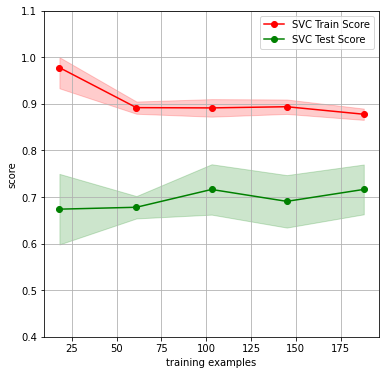

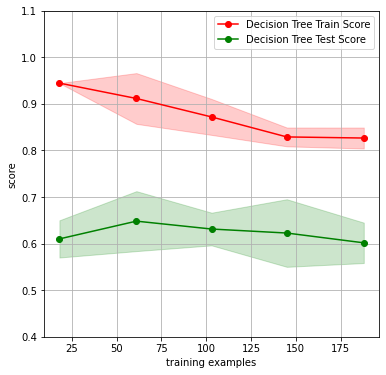

In [45]:
draw_learning_curve(model_svc,X,y,'SVC')
draw_learning_curve(model_dtc,X,y,'Decision Tree')

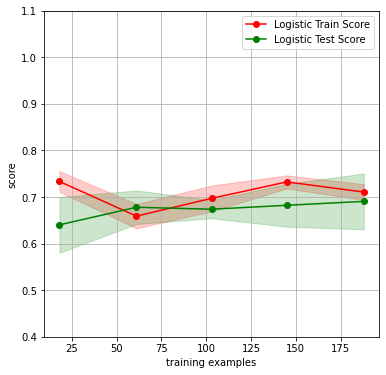

In [35]:
draw_learning_curve(model_log,X,y,'Logistic')

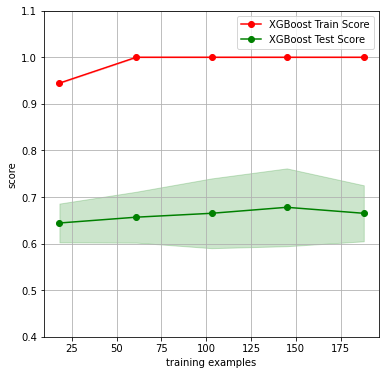

In [27]:
draw_learning_curve(model_xgb,X,y,'XGBoost')

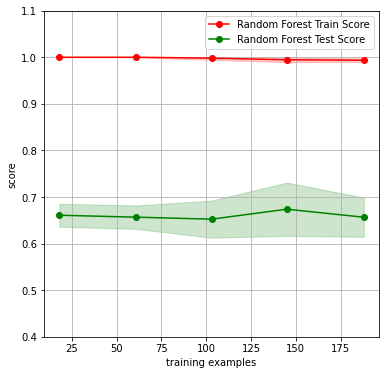

In [28]:
draw_learning_curve(model_rf,X,y,'Random Forest')

In [29]:
print(score_xgb)
print(socre_rf)
print(socre_svc)
print(socre_log)
print(socre_dtc)
print(socre_gbc)

0.3179078014184397
0.33918439716312054
0.27978723404255323
0.31365248226950354
0.3519503546099291
0.3475177304964539


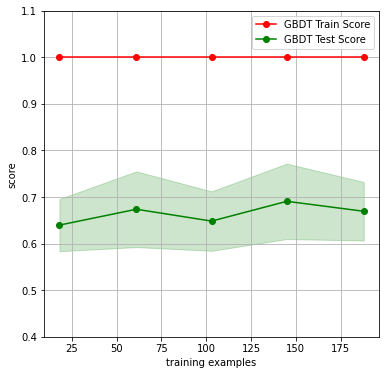

In [30]:
    draw_learning_curve(model_gbc,X,y,'GBDT')